In [1]:
suppressWarnings(suppressPackageStartupMessages({
    library(tidyverse)
    library(data.table)
}))


In [2]:
GBE_ID <- 'HC303'

In [9]:
source('0_parameters.sh')


In [67]:
compute_x_axis_df <- function(don){
    don %>% group_by(CHROM) %>% 
    summarize(center=( max(POS_total) + min(POS_total) ) / 2, .groups = 'drop') %>%
    mutate(CHROM_plot = if_else(CHROM %in% c(1:11, 13, 15, 18, 21, 'X', 'Y'), as.character(CHROM), ''))
}


In [10]:
ukb24983_array_annot_f %>%
fread(colClasses = c('#CHROM'='character')) %>% 
rename_with(function(x){str_replace(x, '#', '')}, starts_with("#")) -> annot_df


In [76]:
annot_df %>%
mutate(CHROM = if_else(CHROM == 'XY', 'X', CHROM)) %>% 
filter(CHROM %in% c(1:22, 'X')) %>%
compute_x_axis_df() -> plot_axis_df


In [26]:
file.path(GBE_data_d, sprintf('%s.tsv', GBE_ID)) %>%
fread(colClasses = c('CHROM'='character')) %>%
left_join(annot_df) %>%
mutate(CHROM = if_else(CHROM == 'XY', 'X', CHROM)) -> PRS_df


Joining, by = c("CHROM", "POS", "ID", "REF", "ALT")



In [30]:
PRS_df %>% colnames

[1] "CHROM"                 "POS"                   "ID"                   
 [4] "REF"                   "ALT"                   "BETA"                 
 [7] "FILTER"                "POS_total"             "Allele"               
[10] "Csq"                   "Consequence"           "SYMBOL"               
[13] "Gene"                  "ld_indep"              "geno_data_source"     
[16] "array"                 "CNV_POS_s"             "CNV_POS_e"            
[19] "UKB_white_british_MAF" "hwe_p"                 "mgi_notes"            
[22] "f_miss"                "f_miss_UKBB"           "f_miss_UKBL"          
[25] "LoF"                   "LoF_filter"            "LoF_flags"            
[28] "LoF_info"              "HGVSp"

In [79]:
PRS_df %>% 
separate(ID, c('HLA_locus', 'HLA_star'), sep='_', extra='drop', fill='right') %>%
mutate(
    plot_label = if_else(
        (Csq %in% c('ptv', 'pav', 'pcv')) & (abs(BETA) > .05),
        SYMBOL,
        ''
    ),
    plot_label = if_else(
        geno_data_source == 'hla',
        paste0('HLA-', str_split(HLA_locus, '_')),
        plot_label
    ),
    plot_label = if_else(
        # https://www.ncbi.nlm.nih.gov/snp/rs9267488
        plot_label == 'ATP6V1G2-DDX39B,ATP6V1G2',
        'ATP6V1G2', plot_label
    ),
    color = if_else(CHROM %in% c(2 * 1:11, 'Y'), "2", "1")
) %>%
ggplot(aes(x = POS_total, y = BETA, color=color, label=plot_label)) +
geom_hline(yintercept = 0, color='black') + geom_point() +
scale_x_continuous(label = plot_axis_df$CHROM_plot, breaks= plot_axis_df$center) +
theme_bw(base_size=16) + theme( 
      legend.position="none",
      panel.border = element_blank(),
      panel.grid.major.x = element_blank(),
      panel.grid.minor.x = element_blank(), 
      axis.ticks = element_blank()
) +
ggrepel::geom_text_repel(size=3, max.overlaps=15) +
labs(
    x='Chromosome', y = 'BETA'
) -> beta_plot


In [81]:
for(ext in c('png', 'pdf')){ggsave(
    sprintf('%s.%s', 'BETAs_HC303', ext),
    beta_plot,
    width=12, height=4
)}


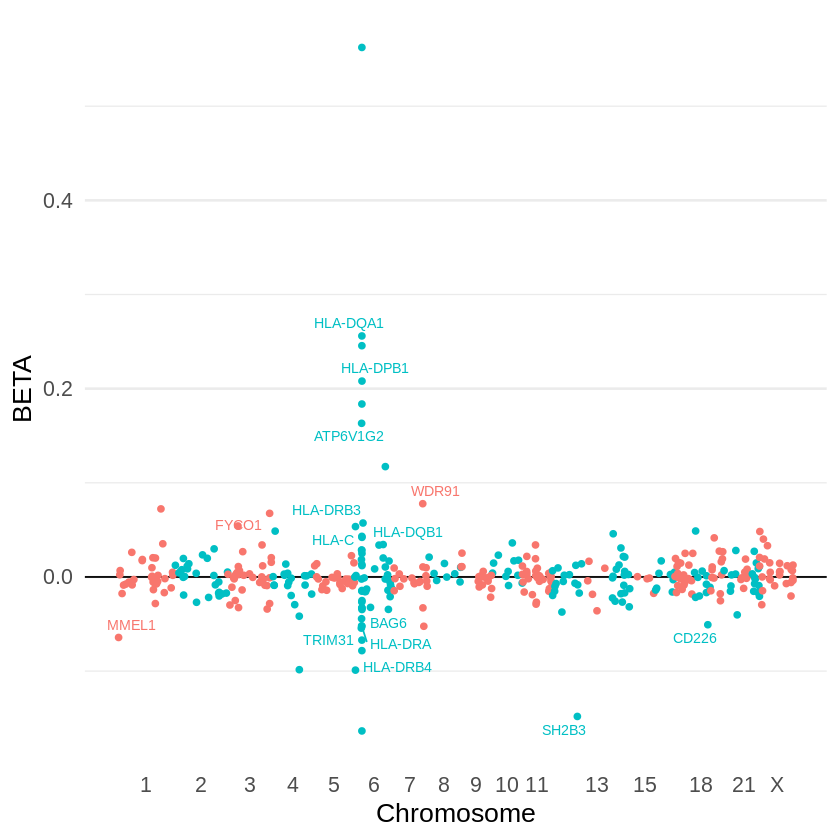

In [80]:
beta_plot